# Amazon Fine Food Reviews Analysis - Analysis using KNN


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [38]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [39]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite')

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

#considering random sample of 100000 due to RAM constraints
filtered_data = filtered_data.sample(n=100000)

# Give reviews with Score > 3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
333271,360630,B000H136JY,A13989MTPASFGN,Karen Honeycutt,0,0,1,1268265600,Great by itself or in cooking,I haven't been able to find this in my local g...
421969,456377,B000G7TBKM,A1LIUOB88X6RSJ,"Leisel ""new online shopper""",0,2,1,1201564800,"Great, but 11 of the 12 bags came.",These pretzels are very tasty when you crave a...
261804,283799,B004EE0TYK,A2ZK5VCQQ4AI18,Roger,5,5,1,1294963200,One of my favorite K-cups,I really like these and always keep them in st...


#  [1.2] Data Preprocessing

## [1.2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [40]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [41]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [42]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(86897, 10)

In [43]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

86.897

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [44]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [45]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [46]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(86897, 10)


1    73246
0    13651
Name: Score, dtype: int64

## 1.2.2  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [47]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

0
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [48]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'my', 'out', 'now', 'ourselves', 'an', 'we', 'with', 'here', 've', 'had', 'because', 'as', 'there', "won't", 'so', "it's", 't', 'such', 'about', 'over', 'once', 'this', 'by', 'should', 'myself', 'in', 'itself', "wouldn't", 'their', "don't", 'down', 'you', 'does', "shan't", 'won', 'themselves', 'why', 'wouldn', 'below', 'when', 'are', "she's", 'for', 'off', 'only', 're', 'do', "weren't", 'some', 'who', 'ours', 'before', 'him', 'hadn', 'if', 'that', 'was', 'a', 'o', 'didn', "you'll", 'couldn', 'mightn', 'needn', 'don', 'd', "hasn't", 'which', 'each', 'further', 'she', 'her', "mustn't", 'through', 'ain', 'they', 'doing', "hadn't", 'then', 'shan', 'than', 'those', 'll', 'until', 'aren', 'our', 'at', "needn't", 'theirs', 'both', 'doesn', "haven't", "didn't", "wasn't", 'will', 'under', "couldn't", 'being', 'did', 'these', 'above', 'me', 'other', 'yourself', 'y', 'them', 'can', 'hasn', "isn't", 'herself', 'into', 'hers', 'any', 'very', 'and', "shouldn't", 'has', 'shouldn', 'his', 'nor', 'too

In [49]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|███████████████████████████████████████████████████████████████████████████| 86897/86897 [02:11<00:00, 658.54it/s]


In [50]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [53]:
final.shape

(86897, 12)

## [1.3]Data Sampling

Note : Data sampling using down sampling is done due to RAM constraints. Where 10k from both +ve and -ve class combined together.

In [55]:
# randomly sampled 10k points from both class
data_pos = final[final["Score"] == 1].sample(n = 10000)
data_neg = final[final["Score"] == 0].sample(n = 10000)
final_20k = pd.concat([data_pos, data_neg])
final_20k.shape

(20000, 12)

In [227]:
# sorting based on time
final_20k["Time"] = pd.to_datetime(final_20k["Time"], unit = "s")
final_20k = final_20k.sort_values(by = "Time")

As part of Data sampling,
1. We have down sampled datasets and combined equal no. of +ve and -ve datasets.
2. Sorted the data based on the time.

## [1.4] KNN analysis for BoW, Tfidf, Avg_W2V and Tfidf_W2V

The below is the general method for K-fold CV. This method when called returns best K(optimal K) value.

In [65]:
# Fuction to compute k value for different algorithms
def k_classifier(X_train, y_train, algorithm):
    # creating odd list of K for KNN
    myList = list(range(0,50))
    neighbors = list(filter(lambda x: x % 2 != 0, myList))

    # empty list that will hold cv scores
    cv_scores = []

    # perform 10-fold cross validation
    for k in neighbors:
        knn = KNeighborsClassifier(n_neighbors=k, algorithm = algorithm)
        scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
        cv_scores.append(scores.mean())

    # changing to misclassification error
    MSE = [1 - x for x in cv_scores]

    # determining best k
    best_k = neighbors[MSE.index(min(MSE))]
    print('\nThe best number of neighbors is %d.' % best_k)

    # plot misclassification error vs k 
    plt.plot(neighbors, MSE)

    for xy in zip(neighbors, np.round(MSE,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
    plt.title("Misclassification Error vs K")
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Misclassification Error')
    plt.show()

    print("The misclassification error for each k value is : ", np.round(MSE,3))
    return best_k

X and y inputs for the model 

In [60]:
# X input for the model
X = final_20k["CleanedText"]
print("shape of X:", X.shape)

# Y input or Class label for the model
y = final_20k["Score"]
print("shape of y:", y.shape)

shape of X: (20000,)
shape of y: (20000,)


Split data into Train and Test

In [62]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape)
print(x_test.shape)
print(y_test.shape)

(14000,) (14000,)
(6000,)
(6000,)


### [1.4.1] KNN Analysis - BoW

In [63]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bag_of_words = CountVectorizer()
X_train = bag_of_words.fit_transform(X_train)
X_train

<14000x15374 sparse matrix of type '<class 'numpy.int64'>'
	with 452351 stored elements in Compressed Sparse Row format>

In [64]:
# Test Vectorizor
x_test = bag_of_words.transform(x_test)
x_test.shape

(6000, 15374)


The optimal number of neighbors is 37.


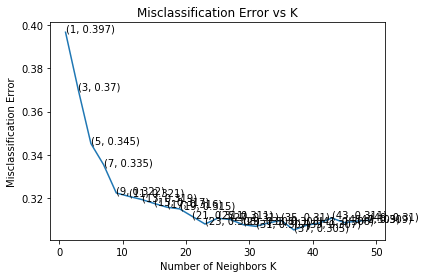

the misclassification error for each k value is :  [0.397 0.37  0.345 0.335 0.322 0.321 0.319 0.317 0.316 0.315 0.311 0.308
 0.311 0.31  0.308 0.307 0.308 0.31  0.305 0.307 0.308 0.311 0.309 0.309
 0.31 ]


37

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

# To choose optimal_k using brute force algorithm
best_k_baw = k_classifier(X_train, y_train, "brute")
print("Best k is : ",best_k_baw)


The optimal number of neighbors is 37.


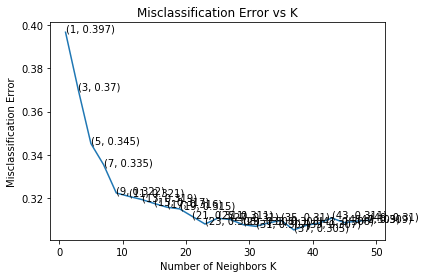

the misclassification error for each k value is :  [0.397 0.37  0.345 0.335 0.322 0.321 0.319 0.317 0.316 0.315 0.311 0.308
 0.311 0.31  0.308 0.307 0.308 0.31  0.305 0.307 0.308 0.311 0.309 0.309
 0.31 ]
Best k is :  37


In [74]:
# To choose optimal_k using "kd tree" force algorithm
best_k_baw_usingKDTree = k_classifier(X_train, y_train, "kd_tree")
print("Best k is : ",best_k_baw_usingKDTree)

================================================================================================================================

Observation :
    1. From "Brute" and "KD Tree" approach we found same best "k" value
    2. Finding best "k" KD Tree approach is faster than Brute approach

In [68]:
# instantiated learning model with best k=27
knn_best_k = KNeighborsClassifier(n_neighbors=best_k_baw)

# fitting the model
knn_best_k.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_best_k.predict(x_test)

In [71]:
# Accuracy on train data
train_accuracy_bow = knn_best_k.score(X_train, y_train)
print("Train accuracy", train_accuracy_bow)

# Error on train data
train_error_bow = 1-train_accuracy_bow
print("Train Error", train_error_bow)

Train accuracy 0.7277857142857143
Train Error 0.27221428571428574


================================================================================================================================

Observation :
          1. Train Accuracy looks good for sub sampled data

In [73]:
# Accuracy on test data
accuracy_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (best_k_baw, accuracy_bow))


The accuracy of the knn classifier for k = 37 is 70.650000%


================================================================================================================================

Observation :
    1. The Accuracy of the KNN classifier using k=37 is 70%.

### [1.4.2] KNN analysis - tfidf

In [85]:
# X input for the model
X = final_20k["CleanedText"]
print("shape of X:", X.shape)

# Y input or Class label for the model
y = final_20k["Score"]
print("shape of y:", y.shape)

shape of X: (20000,)
shape of y: (20000,)


In [86]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape)
print(x_test.shape)
print(y_test.shape)

(14000,) (14000,)
(6000,)
(6000,)


In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
X_train = tf_idf_vect.fit_transform(X_train)

In [88]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
print(x_test.shape)

(6000, 316477)



The optimal number of neighbors is 49.


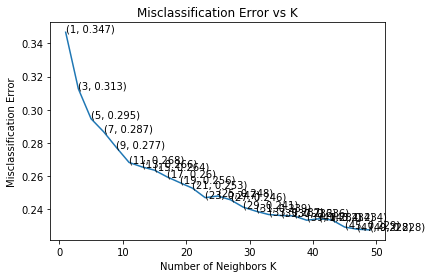

the misclassification error for each k value is :  [0.347 0.313 0.295 0.287 0.277 0.268 0.266 0.264 0.26  0.256 0.253 0.247
 0.248 0.246 0.241 0.239 0.237 0.236 0.236 0.234 0.234 0.234 0.229 0.228
 0.228]


49

In [89]:
best_k_tfidf = k_classifier(X_train, y_train, "brute")
best_k_tfidf

In [90]:
# instantiated learning model with best k=27
knn_best_k = KNeighborsClassifier(n_neighbors=best_k_tfidf)

# fitting the model
knn_best_k.fit(X_train, y_train)
#knn_optimal.fit(bow_data, y_train)

# predict the response
pred = knn_best_k.predict(x_test)

In [91]:
# Accuracy on train data
train_accuracy_bow = knn_best_k.score(X_train, y_train)
print("Train accuracy", train_accuracy_bow)

# Error on train data
train_error_bow = 1-train_accuracy_bow
print("Train Error", train_error_bow)

Train accuracy 0.7922142857142858
Train Error 0.20778571428571424


In [92]:
# Accuracy on test data
accuracy_bow = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (best_k_baw, accuracy_bow))


The accuracy of the knn classifier for k = 37 is 77.983333%


Observations :
    1. KNN using Tfidf we got Accuracy of 77.98%
    2. Accuracy using Tfidf is greater than accuracy using BoW

### [1.4.3] KNN analysis - Avg Word2Vec

In [166]:
# X input for the model
X = final_20k["CleanedText"]
print("shape of X:", X.shape)

# Y input or Class label for the model
y = final_20k["Score"]
print("shape of y:", y.shape)

shape of X: (20000,)
shape of y: (20000,)


In [167]:
# split data into train and test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, y_train.shape)
print(x_test.shape)
print(y_test.shape)

(14000,) (14000,)
(6000,)
(6000,)


In [168]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
#for sent in final_40k['Text'].values:
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [169]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [170]:
w2v_model.wv.most_similar('like')

[('nasti', 0.8378205299377441),
 ('weird', 0.8313934803009033),
 ('strang', 0.8256548643112183),
 ('aw', 0.8080059289932251),
 ('terribl', 0.7968055605888367),
 ('sour', 0.7946043610572815),
 ('odd', 0.7904080152511597),
 ('unpleas', 0.7892770767211914),
 ('bland', 0.7890294194221497),
 ('fishi', 0.7880837321281433)]

In [171]:
w2v = w2v_model[w2v_model.wv.vocab]

In [172]:
w2v.shape

(5435, 50)

In [173]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [174]:
w2v_model=gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [175]:
w2v_model.wv.most_similar('like')

[('realli', 0.976354718208313),
 ('smell', 0.9664018750190735),
 ('tast', 0.9535483121871948),
 ('doesnt', 0.9520435333251953),
 ('textur', 0.9434587359428406),
 ('good', 0.9367963075637817),
 ('butterscotch', 0.9351615309715271),
 ('real', 0.9312963485717773),
 ('didnt', 0.9264622926712036),
 ('artifici', 0.9140938520431519)]

In [176]:
w2v = w2v_model[w2v_model.wv.vocab]

In [177]:
w2v.shape

(3693, 50)

In [178]:
# compute average word2vec for each review.
sent_vectors = [];
for sent in list_of_sent:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.nan_to_num(sent_vectors)
print(len(sent_vectors))
print(len(sent_vectors[0]))

14000
50


In [179]:
# compute average word2vec for each review.

sent_vectors_test = [];
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_words =0;
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.nan_to_num(sent_vectors_test)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

6000
50



The optimal number of neighbors is 37.


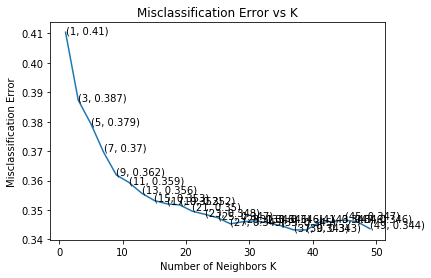

the misclassification error for each k value is :  [0.41  0.387 0.379 0.37  0.362 0.359 0.356 0.353 0.352 0.352 0.35  0.348
 0.347 0.345 0.346 0.346 0.346 0.345 0.343 0.343 0.346 0.346 0.347 0.346
 0.344]


37

In [182]:
X_train = sent_vectors
X_test = sent_vectors_test
best_k_avgw2v = k_classifier(X_train, y_train, "brute")
best_k_avgw2v

In [187]:
# instantiate learning model k = optimal_k
knn_classifier = KNeighborsClassifier(n_neighbors=best_k_avgw2v)

# fitting the model
knn_classifier.fit(X_train, y_train)
    
# predict the response
pred = knn_classifier.predict(X_test)

In [190]:
train_accuracy_aw2vec = knn_classifier.score(X_train, y_train)
print("Train accuracy is  : ", accuracy)
print("Train error is : ", 1 - accuracy)

Train accuracy is  :  0.6864285714285714
Train error is :  0.3135714285714286


In [196]:
accuracy_aw2vec = accuracy_score(y_test, pred) * 100
print("Accuracy of the knn classifier is : ", accuracy_aw2vec)
print("Error using knn classifier is : ",100 - (accuracy_aw2vec))

Accuracy of the knn classifier is :  65.14999999999999
Error using knn classifier is :  34.85000000000001


Observations :
       1. Accuracy using Avg W2V is 65.14%
       2. Accuracy using Avg W2V is less than both BoW and Tfidf.

### [1.4.4] KNN Analysis - Tfidf Weighted W2V

In [197]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1  

In [201]:
print("Length of the TFTDF vector is : ", len(tfidf_sent_vectors))
X_train = tfidf_sent_vectors

Length of the TFTDF vector is :  14000


In [202]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1  

In [218]:
print("Length of tfidf vector : ", len(tfidf_sent_vectors_test))
x_test = tfidf_sent_vectors_test

Length of tfidf vector :  6000


In [219]:
X_train = np.nan_to_num(X_train)
x_test = np.nan_to_num(x_test)


The optimal number of neighbors is 3.


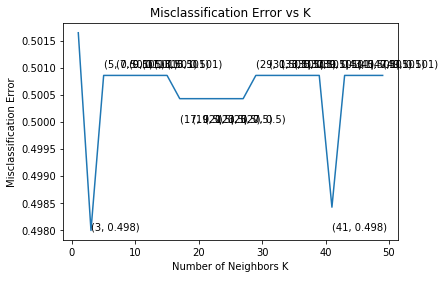

the misclassification error for each k value is :  [0.502 0.498 0.501 0.501 0.501 0.501 0.501 0.501 0.5   0.5   0.5   0.5
 0.5   0.5   0.501 0.501 0.501 0.501 0.501 0.501 0.498 0.501 0.501 0.501
 0.501]


In [205]:
best_k_tfidf_w2v = k_classifier(X_train, y_train, "brute")

In [222]:
# instantiate learning model k = 3
knn_best = KNeighborsClassifier(n_neighbors=best_k_tfidf_w2v)

# fitting the model
knn_best.fit(X_train, y_train)
    
# predict the response
pred = knn_best.predict(x_test)

In [224]:
# Accuracy on train data
train_acc_tfidf_w2v = knn_best.score(X_train, y_train)
print("Train accuracy", train_acc_tfidf_w2v)

Train accuracy 0.502


In [225]:
# Error on train data
train_err_tfidf_w2v = 1-train_acc_tfidf_w2v
print("Train Error %f%%" % (train_err_tfidf_w2v))

Train Error 0.498000%


In [226]:
acc_tfidf_w2v = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (best_k_tfidf_w2v, acc_tfidf_w2v))


The accuracy of the knn classifier for k = 3 is 49.533333%


Observations :
    1. Accuracy using Tdidf_W2V is 49.33%
    2. Accuracy using Tfidf is less than all previous accuracy using BoW, Tfidf and Avg_W2V

## [1.5] Observations :

1. The optimal K found in all the methods are,                                                                                  
    BoW - 37                                                                                                                    
    Tfidf - 37                                                                                                                  
    Avg_W2V - 37                                                                                                                
    Tfidf_W2V - 3                                                                                                               
                                                                                                                                                                                                                                                   
2. The Accuracy found in all the methods are,                                                                                   
   Bow - 70.65%                                                                                                                 
   Tfidf - 77.98%                                                                                                               
   Avg_W2V - 65.14                                                                                                              
   Tfidf_W2V - 49.33%                                                                                                           
                                                                                                                                                                                                                                                      
3. KNN analysis using Tfidf we got higher accuracy than other models.                                                           

## [1.6] Conclusions :

1. Have considered downsampled and balanced dataset
2. BoW and Tfidf resulted in good Accuracy
3. Bias variance trade-off handled with 10 fold CV
4. KNN analysis is not consistant with all the 4 above methods. All 4 methods resulted in different Accuracy.